In [1]:
from torchvision import datasets, transforms

transform = transforms.ToTensor()
train_data = datasets.FashionMNIST(root='../data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='../data', train=False, download=True, transform=transform)

Training set size: 60000
Test set size: 10000
Number of classes: 10
Class names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Image shape: torch.Size([1, 28, 28])


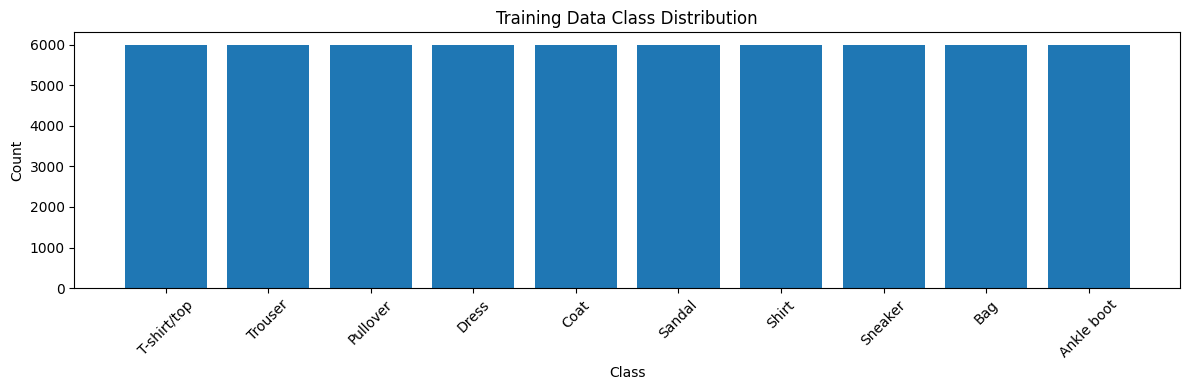

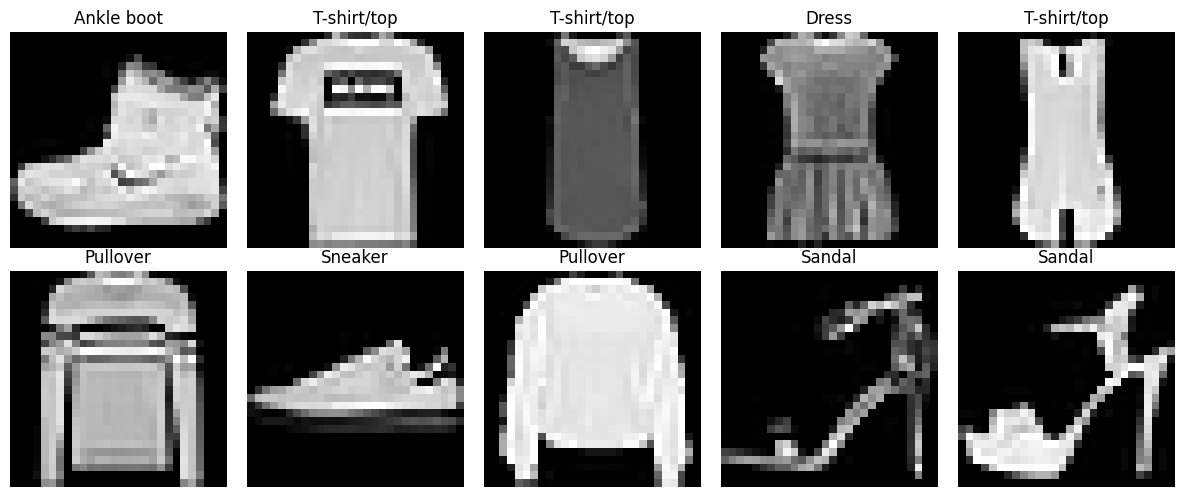

In [2]:
import numpy as np

import matplotlib.pyplot as plt

# Class labels for FashionMNIST
class_names = train_data.classes

# Dataset statistics
print(f"Training set size: {len(train_data)}")
print(f"Test set size: {len(test_data)}")
print(f"Number of classes: {len(class_names)}")
print(f"Class names: {class_names}")
print(f"Image shape: {train_data[0][0].shape}")

# Class distribution
train_labels = [label for _, label in train_data]
unique, counts = np.unique(train_labels, return_counts=True)
plt.figure(figsize=(12, 4))
plt.bar([class_names[i] for i in unique], counts)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Training Data Class Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Display sample images
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    image, label = train_data[i]
    ax.imshow(image.squeeze(), cmap='gray')
    ax.set_title(class_names[label])
    ax.axis('off')
plt.tight_layout()
plt.show()

In [3]:
import torch
from torch.utils.data import DataLoader
import sys
sys.path.append('../src')
import model
import train
import torch.nn as nn

device = None
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available(): # For Apple Silicon GPUs
    device = torch.device("mps")
else:
    device = torch.device("cpu")

# remove code to flatten if testing convolutional model
x_train_flattened = torch.flatten(train_data.data, start_dim=1).float() / 255.0
y_train = train_data.targets

x_test_flattened = torch.flatten(test_data.data, start_dim=1).float() / 255.0
y_test = test_data.targets

train_data_flattened = torch.utils.data.TensorDataset(x_train_flattened, y_train)
test_data_flattened = torch.utils.data.TensorDataset(x_test_flattened, y_test)

loss_histories = []
accuracy_histories = []

print(f"Flattened training data shape: {x_train_flattened.shape}")
print(f"Flattened test data shape: {x_test_flattened.shape}")

test_loader = DataLoader(test_data_flattened, batch_size=64, shuffle=False)

# Create validation set (10% of training data)
val_size = int(0.1 * len(train_data_flattened))
train_size = len(train_data_flattened) - val_size
train_data_split, val_data = torch.utils.data.random_split(train_data_flattened, [train_size, val_size])
train_loader = DataLoader(train_data_split, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

classifier = model.FashionClassifier(hidden_layers=1, activation_fn=nn.ReLU(), hidden_size=512) # change the model here to test other classifiers
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(classifier.parameters(), lr=0.001)


print(f"Using device: {device}")

classifier = classifier.to(device)

FashionClassifier0_loss_history, FashionClassifier0_accuracy_history = train.train_model(classifier, train_loader, val_loader, criterion, optimizer, epochs=5, device=device)
FashionClassifier0_accuracy = train.evaluate_model(classifier, test_loader, device=device)

loss_histories.append(FashionClassifier0_loss_history)
accuracy_histories.append(FashionClassifier0_accuracy_history)


Flattened training data shape: torch.Size([60000, 784])
Flattened test data shape: torch.Size([10000, 784])
Using device: mps
Epoch [1/5] - Loss: 0.5753
Accuracy: 82.92%
Epoch [2/5] - Loss: 0.5714
Accuracy: 84.33%
Epoch [3/5] - Loss: 0.4391
Accuracy: 84.80%
Epoch [4/5] - Loss: 0.3611
Accuracy: 84.93%
Epoch [5/5] - Loss: 0.4751
Accuracy: 84.83%
Accuracy: 83.98%


In [4]:
classifier = model.FashionClassifier(hidden_layers=1, activation_fn=nn.ReLU(), hidden_size=256) # change the model here to test other classifiers
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(classifier.parameters(), lr=0.001)


print(f"Using device: {device}")

classifier = classifier.to(device)

FashionClassifier1_loss_history, FashionClassifier1_accuracy_history = train.train_model(classifier, train_loader, val_loader, criterion, optimizer, epochs=5, device=device)
FashionClassifier1_accuracy = train.evaluate_model(classifier, test_loader, device=device)

loss_histories.append(FashionClassifier1_loss_history)
accuracy_histories.append(FashionClassifier1_accuracy_history)

Using device: mps
Epoch [1/5] - Loss: 0.3423
Accuracy: 82.35%
Epoch [2/5] - Loss: 0.4594
Accuracy: 83.00%
Epoch [3/5] - Loss: 0.2824
Accuracy: 84.57%
Epoch [4/5] - Loss: 0.2689
Accuracy: 84.68%
Epoch [5/5] - Loss: 0.4042
Accuracy: 85.05%
Accuracy: 83.94%


In [5]:
classifier = model.FashionClassifier(hidden_layers=2, activation_fn=nn.ReLU(), hidden_size=128) # change the model here to test other classifiers
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(classifier.parameters(), lr=0.001)


print(f"Using device: {device}")

classifier = classifier.to(device)

FashionClassifier2_loss_history, FashionClassifier2_accuracy_history = train.train_model(classifier, train_loader, val_loader, criterion, optimizer, epochs=5, device=device)
FashionClassifier2_accuracy = train.evaluate_model(classifier, test_loader, device=device)

loss_histories.append(FashionClassifier2_loss_history)
accuracy_histories.append(FashionClassifier2_accuracy_history)

Using device: mps
Epoch [1/5] - Loss: 0.3048
Accuracy: 84.88%
Epoch [2/5] - Loss: 0.4565
Accuracy: 85.67%
Epoch [3/5] - Loss: 0.3725
Accuracy: 86.88%
Epoch [4/5] - Loss: 0.2653
Accuracy: 87.18%
Epoch [5/5] - Loss: 0.3389
Accuracy: 88.08%
Accuracy: 87.05%


In [6]:
classifier = model.FashionClassifier(hidden_layers=3, activation_fn=nn.ReLU(), hidden_size=64) # change the model here to test other classifiers
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(classifier.parameters(), lr=0.001)


print(f"Using device: {device}")

classifier = classifier.to(device)

FashionClassifier3_loss_history, FashionClassifier3_accuracy_history = train.train_model(classifier, train_loader, val_loader, criterion, optimizer, epochs=5, device=device)
FashionClassifier3_accuracy = train.evaluate_model(classifier, test_loader, device=device)

loss_histories.append(FashionClassifier3_loss_history)
accuracy_histories.append(FashionClassifier3_accuracy_history)

Using device: mps
Epoch [1/5] - Loss: 0.3521
Accuracy: 82.98%
Epoch [2/5] - Loss: 0.2758
Accuracy: 85.47%
Epoch [3/5] - Loss: 0.1857
Accuracy: 86.02%
Epoch [4/5] - Loss: 0.5639
Accuracy: 86.95%
Epoch [5/5] - Loss: 0.2942
Accuracy: 86.78%
Accuracy: 86.31%


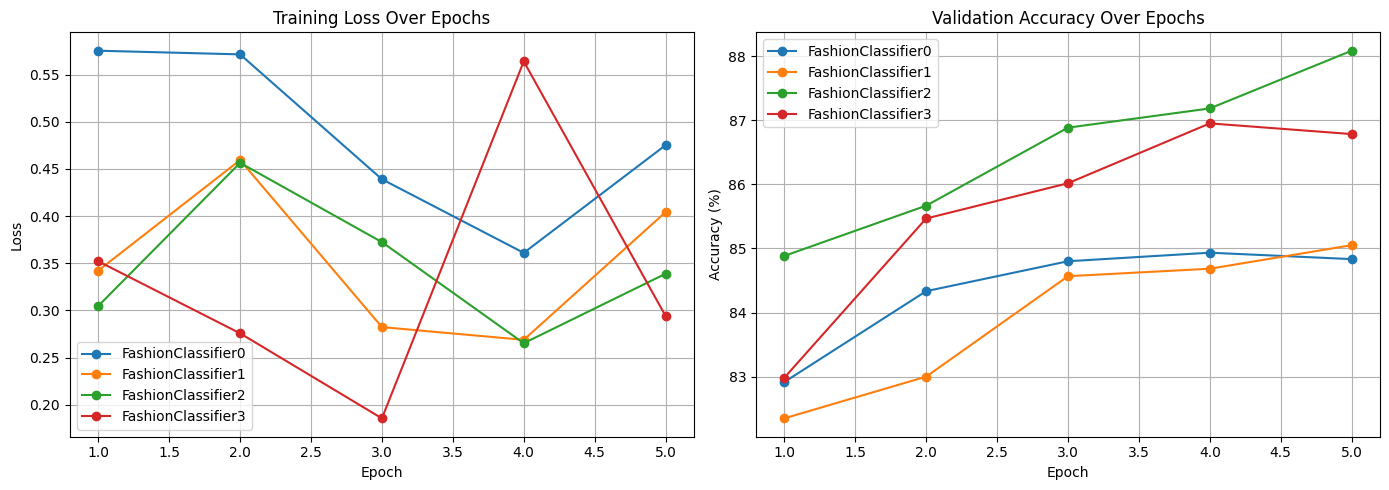


Final Test Accuracies:
FashionClassifier0: 83.98%
FashionClassifier1: 83.94%
FashionClassifier2: 87.05%
FashionClassifier3: 86.31%


In [7]:
# Plot loss histories
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
for i, loss_history in enumerate(loss_histories):
    plt.plot(range(1, len(loss_history) + 1), loss_history, marker='o', label=f'FashionClassifier{i}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)

# Plot accuracy histories
plt.subplot(1, 2, 2)
for i, accuracy_history in enumerate(accuracy_histories):
    plt.plot(range(1, len(accuracy_history) + 1), accuracy_history, marker='o', label=f'FashionClassifier{i}')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print final test accuracies
print("\nFinal Test Accuracies:")
print(f"FashionClassifier0: {FashionClassifier0_accuracy:.2f}%")
print(f"FashionClassifier1: {FashionClassifier1_accuracy:.2f}%")
print(f"FashionClassifier2: {FashionClassifier2_accuracy:.2f}%")
print(f"FashionClassifier3: {FashionClassifier3_accuracy:.2f}%")

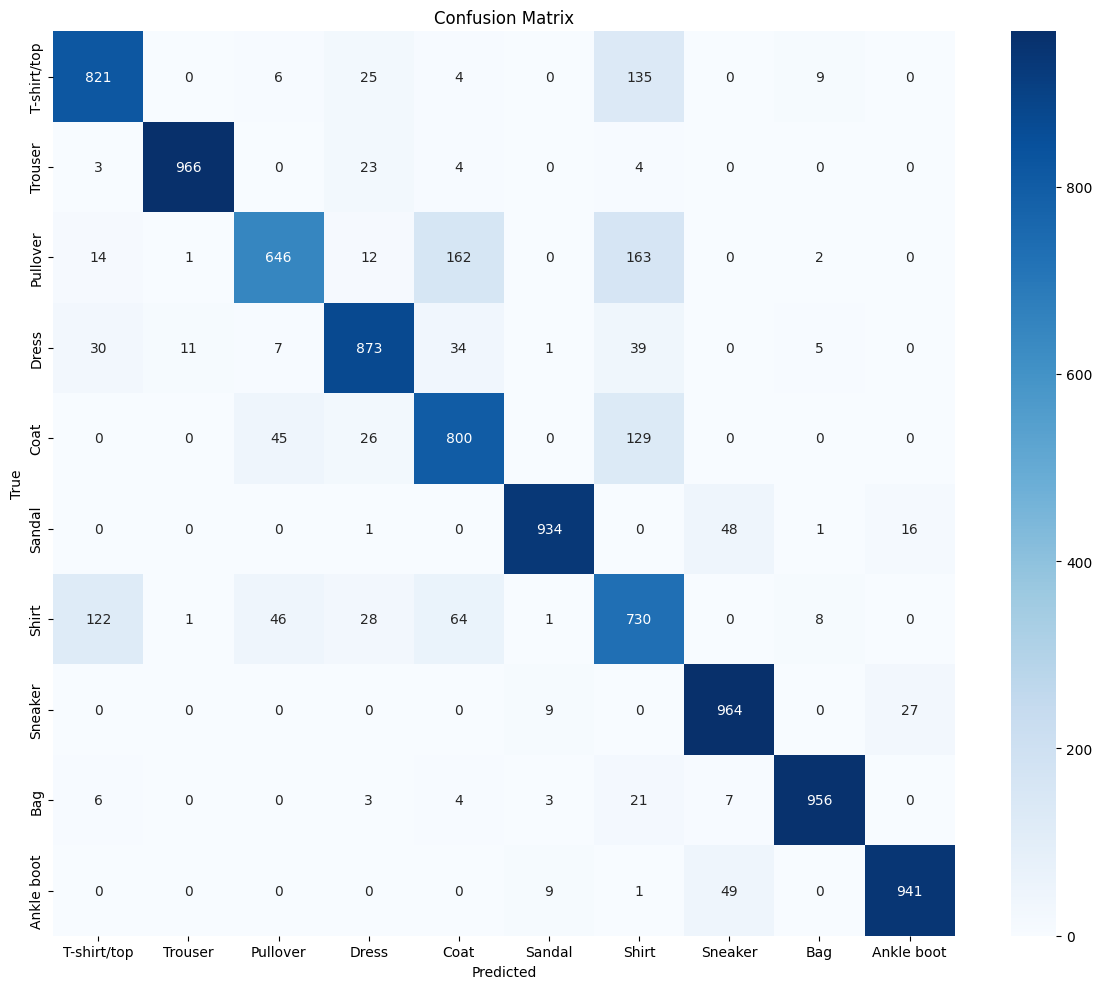

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predictions on test set
classifier.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = classifier(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

# Create confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()